This notebook is designed to teach the basics of Markov Chain Monte Carlo (or MCMC), an extremely useful method for determining best-fit paramters and uncertainties from data. This tutorial will create a toy problem and walk through the process of writing a simple MCMC sampling algorithm to determine credible values of the parameters based on the data at hand.

We will start by importing two handy packages: numpy for array mathematics and a variety of other useful tools, and matplotlib to help us visualize the problem and what the MCMC is doing. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Now, let's create a toy dataset. Let's generate data with a very simple model (a straight line), with only two parameters: a slope and a y-intercept. In particular, the equation of our line is: 

y = slope * x + intercept

In [2]:
x = np.linspace(0, 10, 30)# generate an evenly sampled X axis (not strictly necessary for this problem). 

In [3]:
slope_true = 1.5
intercept_true = 4
uncertainty_true = 1 # These parameters are the "truth" that our MCMC will try to recover.  

In [4]:
y = slope_true * x + intercept_true #Calculate the y values based on the linear model
y = y + np.random.normal(0, uncertainty_true, len(x)) #and add some random noise with
#a Gaussian distribution centered on 0, with a standard deviation of 1. 
err = np.ones_like(y) * uncertainty_true

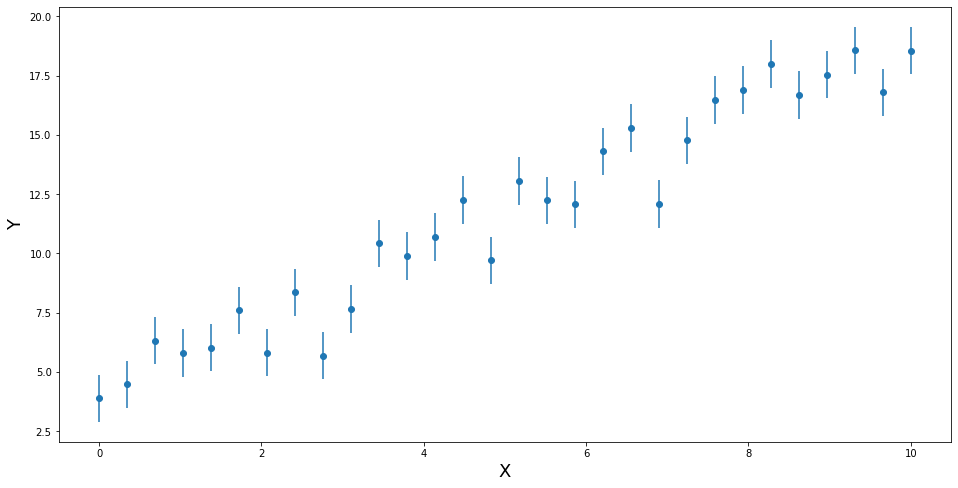

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(x, y, yerr = np.ones_like(y) * uncertainty_true, fmt = 'o')
ax.set_ylabel('Y', fontsize = 18);
ax.set_xlabel('X', fontsize = 18);



Plotted above is our fake dataset. An approximately linear relationship is apparent. Now, let's start to set up our MCMC algorithm.

Markov Chain Monte Carlo gets its name because it jumps randomly (Monte Carlo) through a parameter space building up a list of previously visited positions (a Markov chain). What's special about MCMC is that before it jumps to a new location in parameter space, it decides whether or not the new position is worth visiting (that is, whether the new position is better than, or close enough to its previous position to be worth moving to). This decision making process is the critical ingredient that helps MCMC chains reflect the true underlying probablity distributions of the parameters. 

There are many different specific ways MCMC can select possible new positions and decide whether to jump, so today we will use one of the simplest MCMC sampling methods, known as Metropolis-Hastings. There is a very nice description of this algorithm in Section 2 of Foreman-Mackey et al. (2013), available at https://arxiv.org/abs/1202.3665. 

To start off, we will define some variables for our MCMC. 


In [6]:
npar = 2# Number of free parameters to fit -- in this case, the slope and intercept
nlink = 10000# Length of the chain we ultimately will create

chain = np.zeros([npar, nlink]) * np.nan# the actual Markov chain that we will fill with positions during sampling
likelihoods = np.zeros(nlink) * np.nan# the 

A somewhat tricky parameter to set is a jump width that defines how far away from the current position the MCMC sampler will search for the next position to test. If your jump width is too small, your MCMC will be very slow to explore parameter space. If your jump width is too big, your MCMC will zoom around parameter space too far and fail to home in on the right solution. So this parameter can require some tweaking for good results. More sophisticated samplers, like the affine invariate sampler used by emcee, can circumnvent this problem. 

In [7]:
jumpwidth = np.array([0.1, 0.1])# The data points are in the range of 0-10, and have uncertainties ~ 1, 
#and there are 30 points, so order of magnitude, the data / sqrt(num points) is ~0.1 - 1. So let's try 0.1.  


Now, let's define the likelihood function we wish for the MCMC to evaluate. The likelihood function is has one purpose: to answer the question "What is the probability of observing these data, given our particular model and these particular model parameters?" There are lots of different likelihood functions, but one of the simplest and most common ones used by astronomers is the 𝛘<sup>2</sup> ("chi squared") likelihood function. 

We can calculate 𝛘<sup>2</sup> by the following equation: 
𝛘<sup>2</sup> = Σ<sub>i</sub> (data<sub>i</sub> - model<sub>i</sub>)<sup>2</sup> / error<sub>i</sub><sup>2</sup>. 
Once we have calculated 𝛘<sup>2</sup>, we can calculate the log of the likelihood (in base e): 

log(L) = -0.5𝛘<sup>2</sup> - Σ<sub>i</sub> log(error<sub>i</sub>) - Σ<sub>i</sub> 0.5 log(2π)

An MCMC only cares about the ratio of likelihoods, or the differences of log likelihoods. Since we only care about the comparison of two values, we can drop the third term because 0.5 log(2π) is a constant, and in many cases (when we know the uncertainties) we can drop the second term because it wil be constant as well. In the case of our line with known uncertainties on each point, we can write our function to return: 

log(L) = -0.5𝛘<sup>2</sup>

For our problem, the model is just: 

y = slope * x + intercept

In [8]:
def loglikelihood(p, x, y, e): #here p is an array of the parameters: let's define p[0] = slope, and p[1] = intercept
    slope = p[0]
    intercept = p[1]
    model = slope * x + intercept
    chisq = np.sum((y - model)**2 / e**2)
    loglikelihood = -0.5 * chisq
    return loglikelihood

Now all we need to do is build the MCMC. The code block below has a simple Metropolis Hastings sampler implemented, with detailed comments. 

In [25]:
all_log_likelihoods = np.ones(nlink)#It's not required for the MCMC, but it's a useful thing to have after the fact. 

startpos = np.array([4,8])# At which point in (slope, intercept) space should we start our MCMC? Let's try (1,1). 

for i in range(nlink): #let's loop through the number of links we wish to test
    
    if i == 0: #Our first link is special. We are choosing it ourselves, so the MCMC doesn't have to do anything.
        thisposition = startpos #Assert that it will start at the position we chose.  
        thisloglikelihood = loglikelihood(thisposition, x, y, err)#Calculate the log likelihood at these parameters.
        #Now we can get to the real heart of the algorithm. 
        
    if i >0:# for all other links, we have to randomly choose a new position to test and decide whether to move there
        #or not. 
        lastposition = chain[:,i-1]# Let's grab the last position we landed on the last link. We already calculated 
        #the likelihood value for this link on the last loop through, and stored it in a variable called 
        #"lastloglikelihood". 
        
        trialposition = lastposition + np.random.normal(0, 1, npar) * jumpwidth# randomly draw two samples 
        #from a Gaussian distribution with mean 0 and stdev 1, scale them by jumpwidth, and add them to the last 
        #position to get the new position we will test
        
        trialloglikelihood = loglikelihood(trialposition, x, y, err)#Calculate the log likelihood at this new 
        #trial position
        
        likelihoodratio = np.exp(trialloglikelihood - lastloglikelihood) #Calculate the ratio between the likelihood at the 
        #previous position and the likelihood at this new trial position.

        if likelihoodratio >= np.random.uniform(): #Now, let's draw a random number between 0 and 1, and see if the likelihood 
            #ratio is greater than this number. If the likelihood ratio is greater than this random number, we will
            #jump to the new position. If not, we will stay put. 
            
            # A consequence of this test is that if the parameters at the test position have a higher likelihood than
            # the parameters at the current position, the likelihood ratio is greater than 1, and we will always jump.
            # So an MCMC will always go to a better position if given the chance. 
            
            # But the MCMC will sometimes also go to a slightly worse position, if we happen to draw a low random 
            #number. This is called "decaying" to a worse solution, and this is the key to exploring the full 
            #probability distribution for the parameters. 
            thisposition = trialposition
            thisloglikelihood = trialloglikelihood
            
        else: #If the random number was higher than the likelihood ratio, then we stay put and don't move to 
            #the new position. 
            thisposition = lastposition
            thisloglikelihood = lastloglikelihood
            
    chain[:,i] = thisposition #finally, after we have made our choice whether to move or not, we can add the position
    #we chose to the chains. 
    all_log_likelihoods[i] = thisloglikelihood #We can also update the list of all log likelihoods, which we don't
    #use in the MCMC, but which may come in handy later. 
    lastloglikelihood = thisloglikelihood #and finally, we save the current calculation of log likelihood as the
    #variable "lastloglikelihood" for us to use in the next iteration of the loop. 


What that block of code is doing is actually pretty straightforward. It's looping through each link we requested, drawing new parameters to test, and comparing how well the model with the new test parameters compare to the previous parameters we just tested. If the comparison is favorable, the sampler moves to these new parameters, and if not, it stays put and draws another sample in the next link. Let's plot the chains and visualize how the MCMC moved through parameter space: 

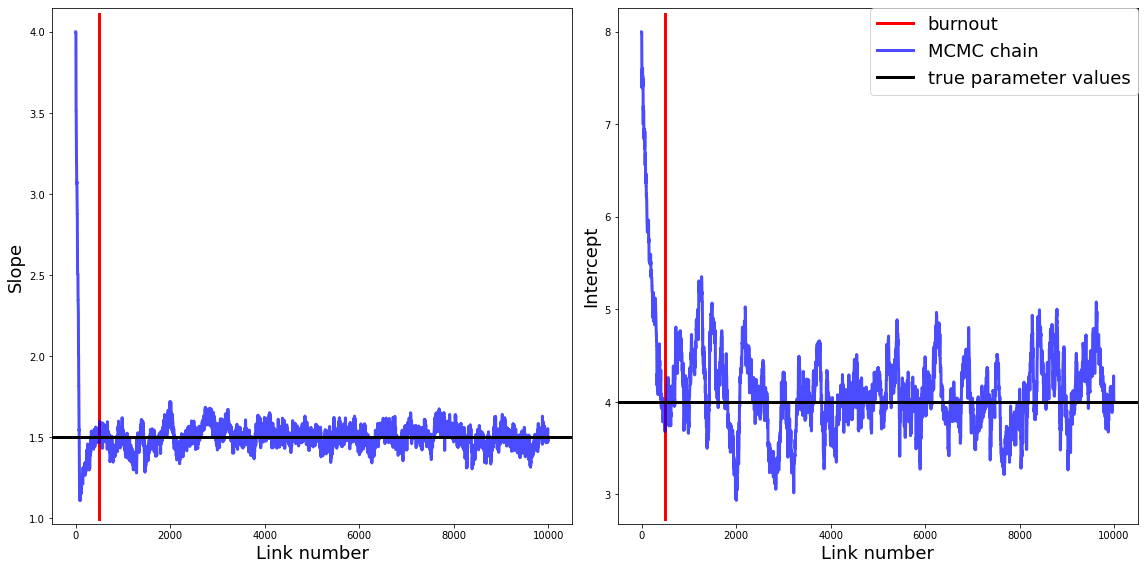

In [40]:
chain_colors = ["#017be4","#ffad63","#9c001f"]
fig, ax = plt.subplots(1,2,figsize=(16, 8))
ax[0].set_ylabel('Slope', fontsize = 18)
ax[0].set_xlabel('Link number', fontsize = 18)
ax[1].set_ylabel('Intercept', fontsize = 18)
ax[1].set_xlabel('Link number', fontsize = 18)
ax[0].axvline(x=500,ymin=0.01,ymax=0.99, color = 'r', linewidth = 3, label = 'burnout')
ax[1].axvline(x=500,ymin=0.01,ymax=0.99, color = 'r', linewidth = 3)
ax[0].plot(chain[0,:], color = 'b', linewidth = 3, label = 'MCMC chain', alpha = 0.7);
ax[1].plot(chain[1,:], color = 'b', linewidth = 3, alpha = 0.7);
ax[0].axhline(slope_true, 0, 1, color = 'k', linewidth = 3, label = 'true parameter values')
ax[1].axhline(intercept_true, 0, 1, color = 'k', linewidth = 3)
fig.legend(fontsize = 18)
fig.tight_layout()

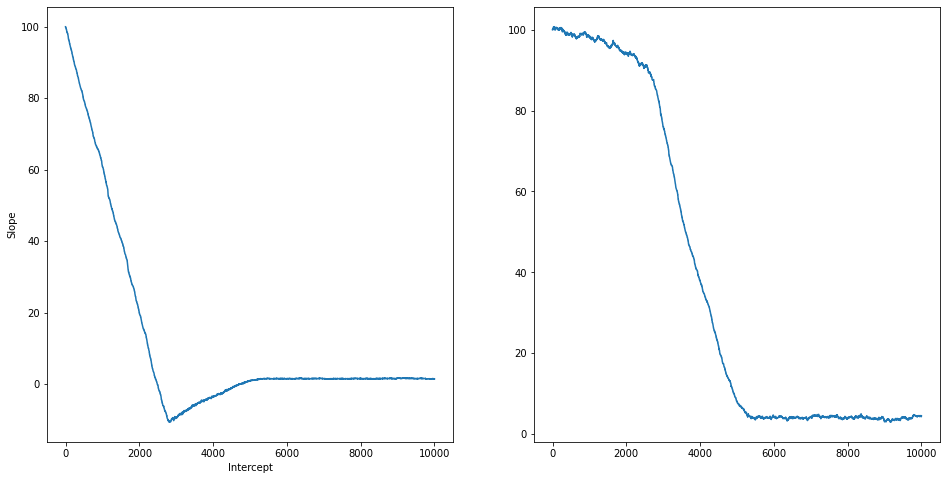

In [14]:
fig, ax = plt.subplots(1,2,figsize=(16, 8))
ax[0].set_ylabel('Slope')
ax[0].set_xlabel('Intercept')
ax[0].plot(chain[0,:]);
ax[1].plot(chain[1,:]);

Both paths show that the MCMC spent the first few hundred links moving quickly towards the best solution, and then bouced around there for the remainder of the sampling. The initial movement is called a "burn-in" phase, and should be discarded before using the MCMC chains for science. 

In [41]:
bchain = chain[:,500:] #clip out the first n links to remove the burn-in phase

We can now use the chains as a proxy for the posterior probability distribution on the slope and intercept. We can plot the posterior distributions with histograms and print out their median values and uncertainties. 

Slope:  1.5 +/- 0.06 , compared to the true value of 1.5
Intercept:  4.06 +/- 0.39 , compared to the true value of 4


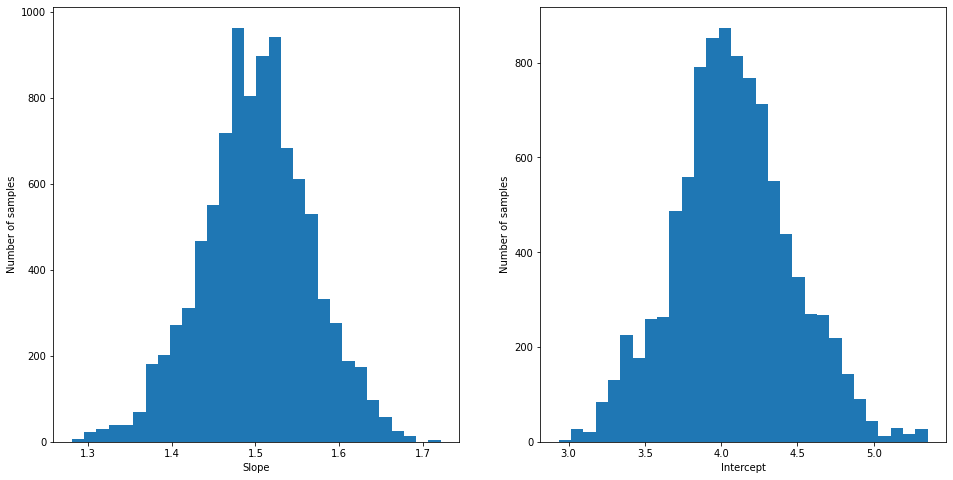

In [42]:
fig, ax = plt.subplots(1,2,figsize=(16, 8))
ax[0].set_ylabel('Number of samples')
ax[0].set_xlabel('Slope')
ax[1].set_ylabel('Number of samples')
ax[1].set_xlabel('Intercept')
ax[0].hist(bchain[0,:], bins = 30);
ax[1].hist(bchain[1,:], bins = 30);
print('Slope: ',round(np.median(bchain[0,:]), 2), '+/-', round(np.std(bchain[0,:]),2), 
      ', compared to the true value of', slope_true)
print('Intercept: ',round(np.median(bchain[1,:]), 2), '+/-', round(np.std(bchain[1,:]),2), 
      ', compared to the true value of', intercept_true)

Another benefit of MCMC is beign able to see how parameter uncertainties relate to each other. Plotting the slope and intercept chains against each other reveals a correlation -- it is easier to achieve a reasonable fit by decreasing the intercept when the slope is increased. 

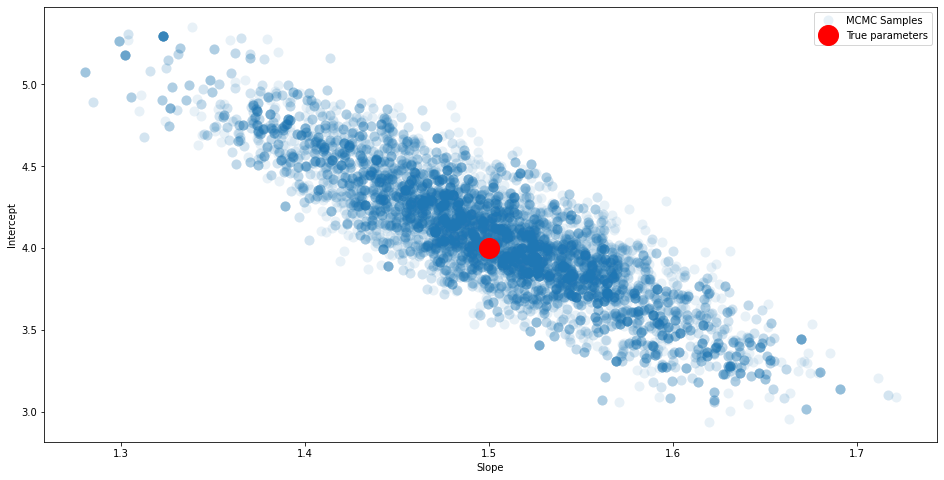

In [43]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(bchain[0,:], bchain[1,:], 'o',alpha = .1, markersize = 10, markeredgewidth=0, label= 'MCMC Samples')
plt.plot(slope_true, intercept_true, 'or', markersize = 20, label = 'True parameters')
ax.set_ylabel('Intercept')
ax.set_xlabel('Slope')
ax.legend()


Finally, we can plot the original data with the best-fit model as determined by the MCMC.

1.4966004676529485
0.06389449358658794
0.06705694485888247
4.120752603198309
0.3951845939751055
0.3946294119704312


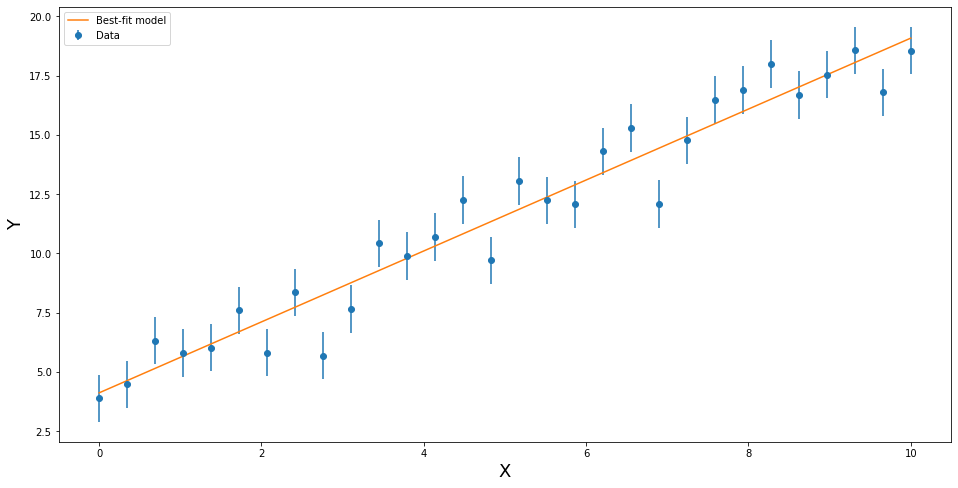

In [44]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(x, y, yerr = np.ones_like(y) * uncertainty_true, fmt = 'o', label = 'Data')
ax.set_ylabel('Y', fontsize = 18);
ax.set_xlabel('X', fontsize = 18);

best = np.argmax(all_log_likelihoods)
bestpar = chain[:,best]
print(bestpar[0])
print(bestpar[0]-np.quantile(chain[0], 0.16))
print(np.quantile(chain[0], 0.84)-bestpar[0])

print(bestpar[1])
print(bestpar[1]-np.quantile(chain[1], 0.16))
print(np.quantile(chain[1], 0.84)-bestpar[1])


model = bestpar[0] * x + bestpar[1]
plt.plot(x, model, label = 'Best-fit model')
plt.legend(loc=2)


And we can add other models drawn from the posterior to indicate the uncertainty about this best fit. 

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(x, y, yerr = np.ones_like(y) * uncertainty_true, fmt = 'o', label = 'Data',zorder=1)
ax.set_ylabel('Y', fontsize = 18);
ax.set_xlabel('X', fontsize = 18);

best = np.argmax(all_log_likelihoods)
bestpar = chain[:,best]
model = bestpar[0] * x + bestpar[1]
plt.plot(x, model, label = 'Best-fit model')
plt.legend(loc=2, fontsize = 18)

draws = np.random.randint(np.size(bchain)/npar, size = 100)
for draw in draws:
    plt.plot(x, bchain[0,draw] * x + bchain[1,draw], zorder=0, color = '#DDDDDD',alpha=0.1)